# Covid-19 visualizations

First, preprocess and clean the data

In [1]:
%reset -f
%config InlineBackend.figure_format = 'svg'

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import datetime
import re
from IPython.display import clear_output

# import classes
import Coviddataclass as cd

# fontsizes for plots
BIG_TEXT   = 18
MED_TEXT   = 14
SMALL_TEXT = 10

In [3]:
# load and clean data
df  = pd.read_csv('https://query.data.world/s/jbgdegbanosfmgly7etz2gxqsbhflk')
df2 = pd.read_csv('state_policy_updates_20201114_0719.csv')
data_cleaner = cd.Coviddataclass()

df, df2 = data_cleaner.clean_data(df, df2)

C:\Users\alexc\Documents\GitHub\covid-19-data-analysis\Coviddataclass.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_cases_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] =\
C:\Users\alexc\Documents\GitHub\covid-19-data-analysis\Coviddataclass.py:82: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['new_deaths_7day'][df['date'] < pd.to_datetime('2020-01-30', format='%Y-%m-%d')] =\


# Get and plot new cases and deaths for a given state / county

In [31]:
def get_cases(df=df, level="county", county="orange", state="California"):
    
    """ A function which filters case_data to a specific county. 
    inputs:  
    level  -- "county" [default] - get county level data
              any other input - get state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    dataFrame -- case_data filtered to a specific county with index=date
    """
    
    if level == "county":
        return  df[(df["location_name"] == county) & (df["state"] == state)].set_index("date")
    
    else: 
        # filter data to desired state
        df = df[df['state'] == state]

        # reindex on location name
        df = df.set_index(["location_name"])

        # get a list of all dates
        all_dates = pd.to_datetime(np.unique(df['date'].to_numpy()))

        # get the state population from county populations
        pop = sum([(pops/1e5) for pops in df[df['date']==all_dates[0]]['total_population']]) 

        # add up the case and death #s that have the same date and state (adding cover counties)
        state_cases       = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['new_cases_1e6' ]]) 
                           for dates in all_dates]

        state_deaths      = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['new_deaths_1e6']]) 
                           for dates in all_dates]

        state_cases_7day  = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['new_cases_7day'   ]]) 
                           for dates in all_dates]

        state_deaths_7day = [sum([(county_cases/pop) for county_cases in df[df['date'] == dates]['new_deaths_7day'  ]]) 
                           for dates in all_dates]
        
        return pd.DataFrame(data={'date'    : all_dates,
                            'new_cases_1e6'  : state_cases, 
                            'new_deaths_1e6' : state_deaths,
                            'new_cases_7day_1e6'    : state_cases_7day,
                            'new_deaths_7day_1e6'   : state_deaths_7day
                            }).set_index(["date"])

In [32]:
get_cases(level="state", state="North Carolina").head()

new_cases_1e6  new_deaths_1e6  new_cases_7day_1e6  \
date                                                            
2020-01-22            0.0             0.0                 0.0   
2020-01-23            0.0             0.0                 0.0   
2020-01-24            0.0             0.0                 0.0   
2020-01-25            0.0             0.0                 0.0   
2020-01-26            0.0             0.0                 0.0   

            new_deaths_7day_1e6  
date                             
2020-01-22                  0.0  
2020-01-23                  0.0  
2020-01-24                  0.0  
2020-01-25                  0.0  
2020-01-26                  0.0

In [33]:
def plot_cases(level="county", county="orange", state="California", df=df, fade=0.75):
    
    """ A function which plots the COVID-19 case/death data and 7 day average
    inputs: 
    level  -- "county" [default] - plot county level data
              any other input - plot state level data
    county -- desired county
    state  -- desired state
    df     -- DataFrame to use, case_data by default
    
    return: 
    [fig, ax] -- figure and axis handles, respectively, for the generated plot
    """
    
    # get the data
    cases = get_cases(level, county, state, df)
        
    # plot the data
    fig, ax = plt.subplots(2, 1, figsize=(12,10), sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style("whitegrid")
    
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
    );

    
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
    );
    
    # format and title axes
    ax[0].set_ylabel("cases per 100,000")
    ax[1].set_ylabel("deaths per 100,000")
    
    
    if level == "county":
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {county} County, {state}");
        
    else: 
        ax[0].set_title(f"Covid-19 cases and deaths per 100,000 in {state}");
    
    
    
    return fig, ax, cases

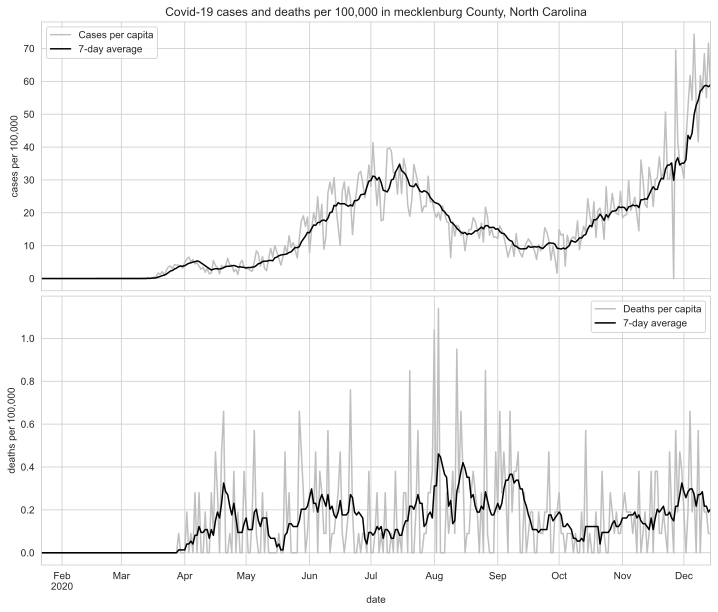

In [34]:
plot_cases(level="county", county="mecklenburg", state="North Carolina");

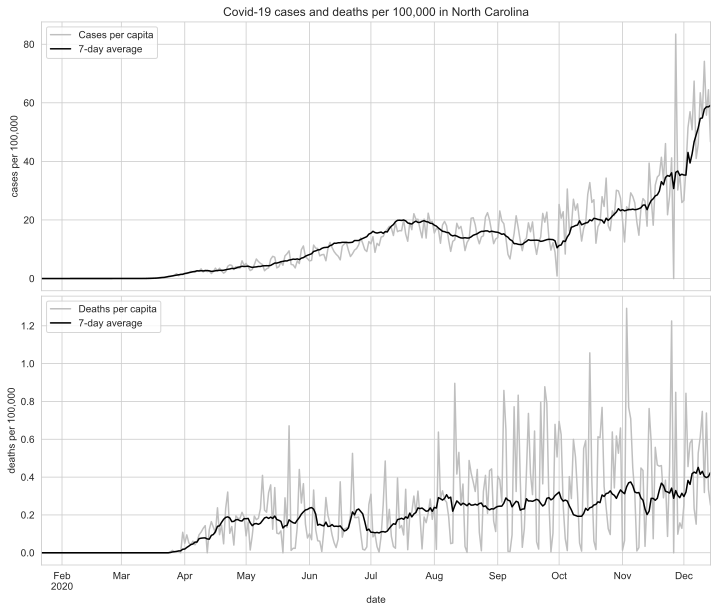

In [35]:
plot_cases(level="state", state="North Carolina");

# Plot case / death rates with selected policies overlaid

In [42]:
def get_policy_data(state="California", county="statewide", state_policies=True, county_policies=True, df=df2):
    
    """A function which returns the policy data at either the state level, county level, or both
    inputs: 
    state -- selected state
    county -- selected county
    state_policies -- include policies at the state level
    county_policies -- include policies at the county level
    
    return: 
    filtered DataFrame
    """

    if state_policies and county_policies:

        policies_filtered = df[

            (df['state_id'] == state) &

            ((df["county"].str.contains(county))  
            | (df["county"].str.contains("statewide"))) 

        ]

    elif state_policies and not county_policies: 
        policies_filtered = df[

            (df['state_id'] == state) &
  
            (df["county"].str.contains("statewide")) 
        ]
    elif not state_policies and county_policies: 
        policies_filtered = df[

            (df['state_id'] == state) &

            (df["county"].str.contains(county))
        ]
        
    return policies_filtered.loc[:, [
        "state_id", 
        "county", 
        "policy_level", 
        "date", 
        "policy_type", 
        "start_stop"
    ]]

In [52]:
def plot_case_and_policies(county, state, 
    colors=['k', 'b', 'r', 'g'],  
    policies=[
        "Mandate Face Masks In Public Spaces", 
        "Mandate Face Masks In Businesses", 
        "Shelter in Place", 
        "State of Emergency"],
                           
    labels=["face mask mandate (public spaces)", 
            "face mask mandate (businesses)", 
            "shelter in place", 
            "state of emergency"], 
    fade=0.75):

    
    """Plot the cases overlayed with the policies. 
    inputs: 
    county -- county of interest
    state  -- state of interest
    policies -- policies to plot
    colors   -- line colors for respective policies (in order)
    labels   -- legend labels for the selected policies
    
    The marks for policies are plotted on the 7 day average, using multiple colors in the case of multiple policies
    in the same day, and using horizontle lines (like an errorbar) if it is a state policy and solid dots if it's a 
    county policy
    """
    plt.figure();
    sns.set_style("whitegrid")
    fig, ax, df = plot_cases(level="county", county=county, state=state, fade=fade);
    

    # get the policy data for the selected state and county 
    policy_data = get_policy_data(state, county);

    # set a solid line to be the start of a policy and a dashed line to be the end
    styles_start_stop = {
        "start": '-', 
        "stop": ':'
    }

    # set color codes for selected policies
    styles_policy_type = {policies[i]: colors[i] for i in range(len(policies))}
    
    # set labels for legend
    legend_policy_labels = {policies[i]: labels[i] for i in range(len(policies))}

    legend_position=(1, 1)
    line_split = 0
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]

    labels = []
    
    # loop through policies and axes
    for i in range(2):

        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # get the y-positional coordinate for the line on the selected day (between 0 and 1) 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
                
            days_serial = (row.date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]

            # loop through all the policies enacted on a given day. Normally, this is 1- but we want to visualize 
            # all the policies enacted on the same day, so we're goint to split the line accordingly 
            
            num_policies = plot_policies['date'].value_counts()[row.date]

            if num_policies > 1: 
                hmin = (cent_coord-mark_length/2) + line_split * (mark_length/num_policies)
                hmax = (cent_coord+mark_length/2) - \
                    (mark_length/num_policies) + ((line_split*mark_length)/num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord-mark_length/2)
                hmax = (cent_coord+mark_length/2)
                line_split=0
            line = ax[i].axvline(x=row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax)

          
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
            if row.policy_level == "state":
                line.set_marker('d')
            else: 
                line.set_marker('o')
            ax[i].legend(loc = "upper left")
        
    # make legend
    legend_lines = []
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label = "state policy"))
    
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label = "county policy"))
    
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    
    leg1 = ax[0].legend(loc='upper left')
    leg2 = ax[0].legend(handles=legend_lines, bbox_to_anchor=legend_position)
    ax[0].add_artist(leg1)
            

<Figure size 432x288 with 0 Axes>

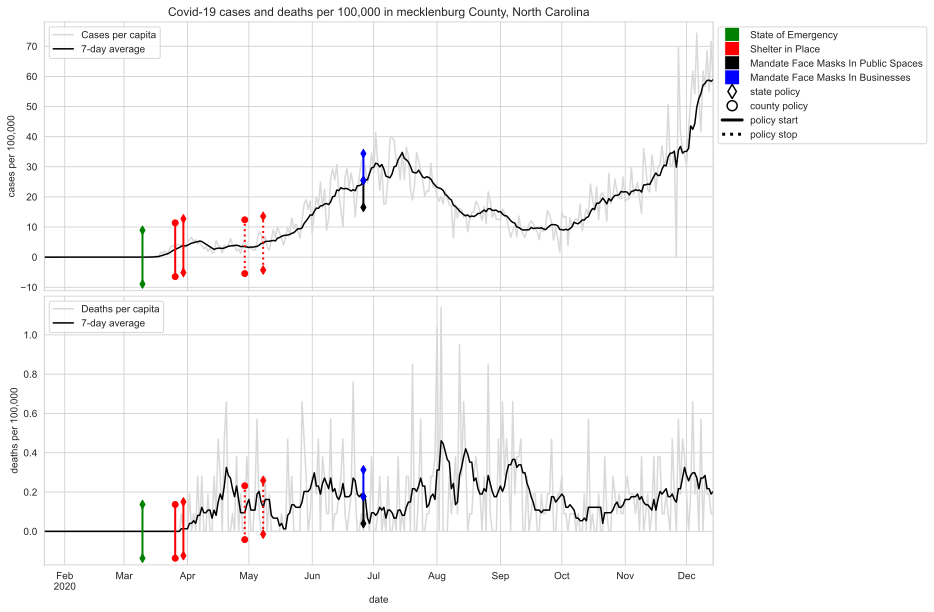

In [54]:
plot_case_and_policies("mecklenburg", "North Carolina", fade=0.85)